In [32]:
pip install pandas numpy matplotlib seaborn scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [62]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib

from pathlib import Path
from scipy.special import expit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
plt.style.use("seaborn-v0_8")
sns.set_context("notebook")

BASE_DATA_DIR = Path("../data")

print("Setup concluído.")
print("Base de dados:", BASE_DATA_DIR.resolve())

Setup concluído.
Base de dados: D:\Documents\GitHub\prototipo-campus\ai\data


In [35]:
historico_dir = BASE_DATA_DIR / "historico"

arquivos_diarios = list(historico_dir.glob("ponto_*/diario/dados_diarios_historico.csv"))

print(f"Total de arquivos diários encontrados: {len(arquivos_diarios)}")

# Carregar todos os arquivos em um único DataFrame
dfs = []

for arquivo in arquivos_diarios:
    df = pd.read_csv(arquivo, parse_dates=["data"])
    
    # Extrair nome do ponto a partir do caminho
    ponto = arquivo.parts[-3].replace("ponto_", "")
    df["ponto"] = ponto
    
    dfs.append(df)

df_diario = pd.concat(dfs, ignore_index=True)

print("Shape do dataset consolidado:", df_diario.shape)
print("\nColunas disponíveis:")
display(df_diario.columns)

print("\nIntervalo temporal:")
print("Início:", df_diario["data"].min())
print("Fim:", df_diario["data"].max())

print("\nExemplo de registros:")
display(df_diario.head())


Total de arquivos diários encontrados: 120
Shape do dataset consolidado: (2058756, 33)

Colunas disponíveis:


Index(['data', 'codigo_clima', 'temperatura_media_2m_C',
       'temperatura_aparente_media_2m_C', 'precipitacao_total_mm',
       'horas_precipitacao', 'fonte', 'local', 'ano', 'mes', 'dia',
       'dia_do_ano', 'dia_da_semana', 'mes_sin', 'mes_cos', 'dia_sin',
       'dia_cos', 'diferenca_temp_aparente', 'precipitacao_ma_7d',
       'precipitacao_ma_30d', 'precipitacao_ma_90d', 'anomalia_precip_7d',
       'anomalia_precip_30d', 'intensidade_precipitacao',
       'precipitacao_lag_1d', 'precipitacao_lag_2d', 'precipitacao_lag_3d',
       'precipitacao_lag_7d', 'precipitacao_lag_14d', 'precipitacao_lag_30d',
       'temperatura_lag_1d', 'temperatura_lag_7d', 'ponto'],
      dtype='object')


Intervalo temporal:
Início: 1940-01-01 00:00:00
Fim: 2025-12-21 00:00:00

Exemplo de registros:


,data,codigo_clima,temperatura_media_2m_C,temperatura_aparente_media_2m_C,precipitacao_total_mm,horas_precipitacao,fonte,local,ano,mes,...,intensidade_precipitacao,precipitacao_lag_1d,precipitacao_lag_2d,precipitacao_lag_3d,precipitacao_lag_7d,precipitacao_lag_14d,precipitacao_lag_30d,temperatura_lag_1d,temperatura_lag_7d,ponto
0,1980-01-01,61,21.2,23.7,14.4,22.0,historico,Alameda_Iracema_Caldas_de_Almeida,1980,1,...,0.654545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alameda_Iracema_Caldas_de_Almeida
1,1980-01-02,51,21.9,24.1,2.5,14.0,historico,Alameda_Iracema_Caldas_de_Almeida,1980,1,...,0.178571,14.4,NaN,NaN,NaN,NaN,NaN,21.2,NaN,Alameda_Iracema_Caldas_de_Almeida
2,1980-01-03,51,22.3,23.5,0.1,1.0,historico,Alameda_Iracema_Caldas_de_Almeida,1980,1,...,0.100000,2.5,14.4,NaN,NaN,NaN,NaN,21.9,NaN,Alameda_Iracema_Caldas_de_Almeida
3,1980-01-04,2,22.6,24.1,0.0,0.0,historico,Alameda_Iracema_Caldas_de_Almeida,1980,1,...,0.000000,0.1,2.5,14.4,NaN,NaN,NaN,22.3,NaN,Alameda_Iracema_Caldas_de_Almeida
4,1980-01-05,53,23.4,25.3,0.7,1.0,historico,Alameda_Iracema_Caldas_de_Almeida,1980,1,...,0.700000,0.0,0.1,2.5,NaN,NaN,NaN,22.6,NaN,Alameda_Iracema_Caldas_de_Almeida


In [36]:
DATA_CORTE = pd.Timestamp("1980-01-01")

df_diario = df_diario[df_diario["data"] >= DATA_CORTE].copy()

print("Dataset após corte temporal (>= 1980)")
print("Shape:", df_diario.shape)

print("\nNovo intervalo temporal:")
print("Início:", df_diario["data"].min())
print("Fim:", df_diario["data"].max())

# Checagem básica de valores negativos estranhos
print("\nChecagem de precipitação negativa:")
print((df_diario["precipitacao_total_mm"] < 0).sum())

# Estatísticas rápidas
display(
    df_diario[[
        "precipitacao_total_mm",
        "precipitacao_ma_7d",
        "precipitacao_ma_30d",
        "intensidade_precipitacao"
    ]].describe()
)

Dataset após corte temporal (>= 1980)
Shape: (2014926, 33)

Novo intervalo temporal:
Início: 1980-01-01 00:00:00
Fim: 2025-12-21 00:00:00

Checagem de precipitação negativa:
0


,precipitacao_total_mm,precipitacao_ma_7d,precipitacao_ma_30d,intensidade_precipitacao
count,2.014926e+06,2.014926e+06,2.014926e+06,2.014926e+06
mean,3.310043e+00,3.309561e+00,3.309367e+00,3.596633e-01
std,6.062973e+00,4.149232e+00,3.265599e+00,4.960154e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.733333e-01,0.000000e+00
50%,2.000000e-01,1.657143e+00,2.573333e+00,1.250000e-01
75%,4.500000e+00,5.628571e+00,5.630000e+00,6.000000e-01
max,1.585000e+02,5.951429e+01,2.114667e+01,7.800000e+00


In [37]:
# Quantis de referência
QUANTIS = [0.90, 0.95, 0.99]

quantis_ponto = (
    df_diario
    .groupby("ponto")["precipitacao_total_mm"]
    .quantile(QUANTIS)
    .unstack()
    .reset_index()
    .rename(columns={
        0.90: "q90_precip",
        0.95: "q95_precip",
        0.99: "q99_precip"
    })
)

print("Quantis calculados por ponto:")
display(quantis_ponto.head())

print("\nResumo estatístico dos quantis:")
display(quantis_ponto.describe())

# Merge com o dataset principal
df_diario = df_diario.merge(quantis_ponto, on="ponto", how="left")

print("\nColunas após merge dos quantis:")
display(df_diario[["ponto", "q90_precip", "q95_precip", "q99_precip"]].head())


Quantis calculados por ponto:


,ponto,q90_precip,q95_precip,q99_precip
0,Alameda_Iracema_Caldas_de_Almeida,10.9,15.1,25.40
1,Alameda_LB_15,10.9,15.1,25.31
2,Alameda_Miro,10.9,15.1,25.40
3,Alameda_Modligliane,10.9,15.1,25.40
4,Alameda_Mondrian,10.9,15.1,25.40



Resumo estatístico dos quantis:


,q90_precip,q95_precip,q99_precip
count,120.000000,120.000000,120.000000
mean,10.986667,15.243708,25.339333
std,0.436551,0.452331,0.248230
min,10.800000,15.050000,25.100000
25%,10.800000,15.100000,25.200000
50%,10.900000,15.100000,25.310000
75%,10.900000,15.100000,25.400000
max,13.000000,17.300000,26.800000



Colunas após merge dos quantis:


,ponto,q90_precip,q95_precip,q99_precip
0,Alameda_Iracema_Caldas_de_Almeida,10.9,15.1,25.4
1,Alameda_Iracema_Caldas_de_Almeida,10.9,15.1,25.4
2,Alameda_Iracema_Caldas_de_Almeida,10.9,15.1,25.4
3,Alameda_Iracema_Caldas_de_Almeida,10.9,15.1,25.4
4,Alameda_Iracema_Caldas_de_Almeida,10.9,15.1,25.4


In [38]:

EPS = 1e-6  # proteção numérica

# (A) Magnitude da precipitação diária (normalizada pelo q95 do ponto)
df_diario["comp_magnitude"] = (
    df_diario["precipitacao_total_mm"] /
    (df_diario["q95_precip"] + EPS)
)

# (B) Persistência / saturação (média ponderada 7d e 30d)
df_diario["comp_saturacao"] = (
    0.6 * (df_diario["precipitacao_ma_7d"] / (df_diario["q95_precip"] + EPS)) +
    0.4 * (df_diario["precipitacao_ma_30d"] / (df_diario["q95_precip"] + EPS))
)

# (C) Anomalia positiva (somente excesso)
df_diario["comp_anomalia"] = (
    df_diario[["anomalia_precip_7d", "anomalia_precip_30d"]]
    .clip(lower=0)
    .max(axis=1)
) / (df_diario["q95_precip"] + EPS)

# (D) Intensidade efetiva (já está quase normalizada)
df_diario["comp_intensidade"] = df_diario["intensidade_precipitacao"]

# (E) Vulnerabilidade histórica do ponto
# (q90 local comparado ao q95 médio global)
q95_global = df_diario["q95_precip"].mean()

df_diario["comp_vulnerabilidade"] = (
    df_diario["q90_precip"] / (q95_global + EPS)
)

componentes = [
    "comp_magnitude",
    "comp_saturacao",
    "comp_anomalia",
    "comp_intensidade",
    "comp_vulnerabilidade"
]

display(df_diario[componentes].describe())


,comp_magnitude,comp_saturacao,comp_anomalia,comp_intensidade,comp_vulnerabilidade
count,2.014926e+06,2.014926e+06,2.014926e+06,2.014926e+06,2.014926e+06
mean,2.170799e-01,2.170432e-01,1.092211e-01,3.596633e-01,7.207345e-01
std,3.977386e-01,2.350569e-01,2.871898e-01,4.960154e-01,2.851852e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.084890e-01
25%,0.000000e+00,8.338063e-03,0.000000e+00,0.000000e+00,7.084890e-01
50%,1.324503e-02,1.475749e-01,0.000000e+00,1.250000e-01,7.150491e-01
75%,2.980132e-01,3.686376e-01,5.231788e-02,6.000000e-01,7.150491e-01
max,1.009554e+01,2.861610e+00,9.436942e+00,7.800000e+00,8.528108e-01


Estatísticas do ICRA:


count    2.014926e+06
mean     7.937776e-01
std      1.161483e-01
min      6.700672e-01
25%      6.770275e-01
50%      7.631489e-01
75%      9.055690e-01
max      1.000000e+00
Name: icra_target, dtype: float64

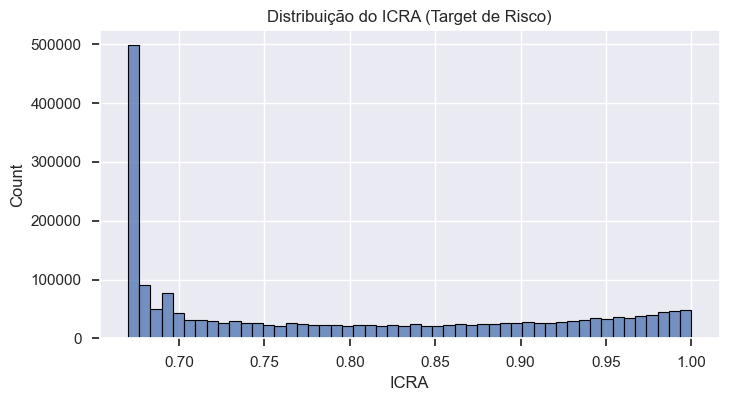

In [39]:
# Combinação linear dos componentes
df_diario["icra_linear"] = (
    1.2 * df_diario["comp_magnitude"] +
    1.5 * df_diario["comp_saturacao"] +
    1.0 * df_diario["comp_anomalia"] +
    0.8 * df_diario["comp_intensidade"] +
    1.0 * df_diario["comp_vulnerabilidade"]
)

# Aplicação da sigmoide → escala [0,1]
df_diario["icra_target"] = expit(df_diario["icra_linear"])

print("Estatísticas do ICRA:")
display(df_diario["icra_target"].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df_diario["icra_target"], bins=50)
plt.title("Distribuição do ICRA (Target de Risco)")
plt.xlabel("ICRA")
plt.show()

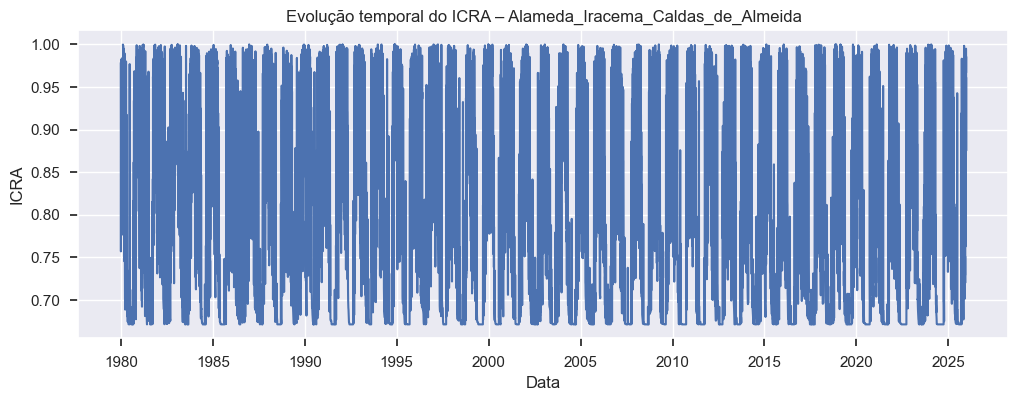

In [40]:
ponto_exemplo = df_diario["ponto"].iloc[0]

df_exemplo = df_diario[df_diario["ponto"] == ponto_exemplo].sort_values("data")

plt.figure(figsize=(12, 4))
plt.plot(df_exemplo["data"], df_exemplo["icra_target"])
plt.title(f"Evolução temporal do ICRA – {ponto_exemplo}")
plt.ylabel("ICRA")
plt.xlabel("Data")
plt.show()

In [41]:
EPS = 1e-6

# Magnitude da precipitação (normalizada por ponto)
df["comp_magnitude"] = (
    df["precipitacao_total_mm"] /
    (df.groupby("ponto")["precipitacao_total_mm"].transform("quantile", 0.99) + EPS)
).clip(0, 1)

# Saturação do solo (média móvel longa)
df["comp_saturacao"] = (
    df["precipitacao_ma_90d"] /
    (df.groupby("ponto")["precipitacao_ma_90d"].transform("max") + EPS)
).clip(0, 1)

# Anomalia de precipitação
anomalia_abs = df["anomalia_precip_30d"].abs()
df["comp_anomalia"] = (
    anomalia_abs /
    (anomalia_abs.groupby(df["ponto"]).transform("quantile", 0.99) + EPS)
).clip(0, 1)

# Intensidade da chuva
df["comp_intensidade"] = (
    df["intensidade_precipitacao"] /
    (df.groupby("ponto")["intensidade_precipitacao"].transform("quantile", 0.99) + EPS)
).clip(0, 1)

# Vulnerabilidade estrutural (fixa por ponto)
vulnerabilidade_por_ponto = (
    df.groupby("ponto")["precipitacao_ma_30d"].mean()
)
vulnerabilidade_por_ponto = (
    vulnerabilidade_por_ponto / vulnerabilidade_por_ponto.max()
)

df["comp_vulnerabilidade"] = df["ponto"].map(vulnerabilidade_por_ponto)

print("Componentes do ICRA criados com sucesso!")
df[[
    "comp_magnitude",
    "comp_saturacao",
    "comp_anomalia",
    "comp_intensidade",
    "comp_vulnerabilidade"
]].describe()




Componentes do ICRA criados com sucesso!


,comp_magnitude,comp_saturacao,comp_anomalia,comp_intensidade,comp_vulnerabilidade
count,16791.000000,16791.000000,16791.000000,16791.000000,16791.0
mean,0.124807,0.227262,0.155278,0.178932,1.0
std,0.210120,0.185179,0.194854,0.237942,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.045370,0.008611,0.000000,1.0
50%,0.007874,0.205170,0.084316,0.051282,1.0
75%,0.173228,0.384877,0.233931,0.307692,1.0
max,1.000000,1.000000,1.000000,1.000000,1.0


In [42]:
w_magnitude = 0.30
w_saturacao = 0.25
w_anomalia = 0.20
w_intensidade = 0.15
w_vulnerabilidade = 0.10

df["icra_raw"] = (
    w_magnitude * df["comp_magnitude"] +
    w_saturacao * df["comp_saturacao"] +
    w_anomalia * df["comp_anomalia"] +
    w_intensidade * df["comp_intensidade"] +
    w_vulnerabilidade * df["comp_vulnerabilidade"]
)

df["icra_target"] = (
    (df["icra_raw"] - df["icra_raw"].min()) /
    (df["icra_raw"].max() - df["icra_raw"].min())
)

print("ICRA final criado com sucesso!")
df["icra_target"].describe()


ICRA final criado com sucesso!


count    16791.000000
mean         0.183955
std          0.182491
min          0.000000
25%          0.030375
50%          0.142153
75%          0.277573
max          1.000000
Name: icra_target, dtype: float64

In [43]:
df_model = df.sort_values("data").reset_index(drop=True)

# Features finais 
FEATURES = [
    "precipitacao_total_mm",
    "precipitacao_ma_7d",
    "precipitacao_ma_30d",
    "precipitacao_ma_90d",
    "anomalia_precip_7d",
    "anomalia_precip_30d",
    "intensidade_precipitacao",
    "precipitacao_lag_1d",
    "precipitacao_lag_2d",
    "precipitacao_lag_3d",
    "precipitacao_lag_7d",
    "precipitacao_lag_14d",
    "precipitacao_lag_30d",
    "temperatura_media_2m_C",
    "temperatura_aparente_media_2m_C",
    "temperatura_lag_1d",
    "temperatura_lag_7d",
    "mes_sin",
    "mes_cos",
    "dia_sin",
    "dia_cos"
]

TARGET = "icra_target"

# Remover NaNs gerados por lags
df_model = df_model[FEATURES + [TARGET, "data"]].dropna()

# Datas de corte
DATA_TREINO_FIM = "2015-12-31"
DATA_VALID_FIM = "2020-12-31"

train = df_model[df_model["data"] <= DATA_TREINO_FIM]
valid = df_model[
    (df_model["data"] > DATA_TREINO_FIM) &
    (df_model["data"] <= DATA_VALID_FIM)
]
test = df_model[df_model["data"] > DATA_VALID_FIM]

X_train, y_train = train[FEATURES], train[TARGET]
X_valid, y_valid = valid[FEATURES], valid[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

print("Split temporal:")
print(f"Treino: {X_train.shape}")
print(f"Validação: {X_valid.shape}")
print(f"Teste: {X_test.shape}")


Split temporal:
Treino: (13119, 21)
Validação: (1827, 21)
Teste: (1815, 21)


In [44]:
# Modelo
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Previsões
pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)
pred_test = model.predict(X_test)

# Métricas
def avaliar(y_true, y_pred, nome):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{nome}: RMSE={rmse:.4f} | MAE={mae:.4f} | R2={r2:.4f}")

print("\nDesempenho do modelo:")
avaliar(y_train, pred_train, "Treino")
avaliar(y_valid, pred_valid, "Validação")
avaliar(y_test, pred_test, "Teste")



Desempenho do modelo:
Treino: RMSE=0.0174 | MAE=0.0095 | R2=0.9911
Validação: RMSE=0.0158 | MAE=0.0090 | R2=0.9913
Teste: RMSE=0.0158 | MAE=0.0084 | R2=0.9913


In [45]:
# Criar dataframe de teste com previsões
df_test_eval = test.copy()
df_test_eval["icra_pred"] = pred_test
df_test_eval["erro_abs"] = abs(df_test_eval[TARGET] - df_test_eval["icra_pred"])

# Definir limiares de risco
q90 = df_test_eval[TARGET].quantile(0.90)
q95 = df_test_eval[TARGET].quantile(0.95)

alto_risco_90 = df_test_eval[df_test_eval[TARGET] >= q90]
alto_risco_95 = df_test_eval[df_test_eval[TARGET] >= q95]

def resumo_extremos(df_ext, nome):
    rmse = np.sqrt(mean_squared_error(df_ext[TARGET], df_ext["icra_pred"]))
    mae = mean_absolute_error(df_ext[TARGET], df_ext["icra_pred"])
    print(f"{nome}: RMSE={rmse:.4f} | MAE={mae:.4f} | N={len(df_ext)}")

print("Avaliação em eventos extremos:")
resumo_extremos(alto_risco_90, "Top 10% de risco")
resumo_extremos(alto_risco_95, "Top 5% de risco")


Avaliação em eventos extremos:
Top 10% de risco: RMSE=0.0330 | MAE=0.0258 | N=182
Top 5% de risco: RMSE=0.0363 | MAE=0.0287 | N=91


Top 10 variáveis mais importantes:


precipitacao_total_mm       0.738772
precipitacao_ma_30d         0.189860
precipitacao_ma_90d         0.047771
intensidade_precipitacao    0.021607
dia_sin                     0.001506
anomalia_precip_30d         0.000434
anomalia_precip_7d          0.000023
mes_sin                     0.000017
precipitacao_ma_7d          0.000004
dia_cos                     0.000003
dtype: float64

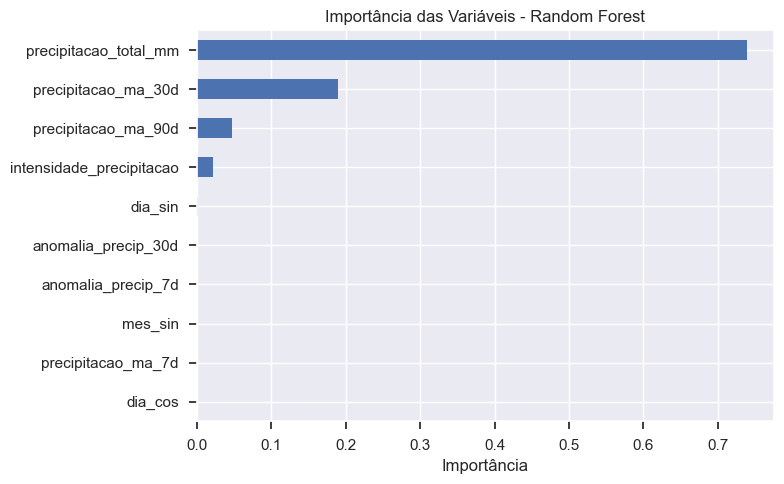

In [46]:
importances = pd.Series(
    model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

print("Top 10 variáveis mais importantes:")
display(importances.head(10))

plt.figure(figsize=(8,5))
importances.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

In [47]:
# Definir thresholds com base na distribuição histórica
q50 = df[TARGET].quantile(0.50)
q75 = df[TARGET].quantile(0.75)
q90 = df[TARGET].quantile(0.90)
q95 = df[TARGET].quantile(0.95)

thresholds = {
    "Baixo": (0.0, q50),
    "Moderado": (q50, q75),
    "Alto": (q75, q90),
    "Muito Alto": (q90, 1.0)
}

print("Thresholds de risco (ICRA):")
for nivel, (lo, hi) in thresholds.items():
    print(f"{nivel}: [{lo:.3f}, {hi:.3f})")


Thresholds de risco (ICRA):
Baixo: [0.000, 0.142)
Moderado: [0.142, 0.278)
Alto: [0.278, 0.426)
Muito Alto: [0.426, 1.000)


In [48]:
# Selecionar últimos registros conhecidos (ex: últimos 30 dias)
df_recent = df_model.tail(30).copy()

# Prever risco
df_recent["icra_pred"] = model.predict(df_recent[FEATURES])

# Classificar risco
def classificar_risco(valor, thresholds):
    for nivel, (lo, hi) in thresholds.items():
        if lo <= valor < hi:
            return nivel
    return "Muito Alto"

df_recent["nivel_risco"] = df_recent["icra_pred"].apply(
    lambda x: classificar_risco(x, thresholds)
)

display(df_recent[["data", "icra_pred", "nivel_risco"]].tail(10))


,data,icra_pred,nivel_risco
16781,2025-12-11,0.114387,Baixo
16782,2025-12-12,0.102649,Baixo
16783,2025-12-13,0.151087,Moderado
16784,2025-12-14,0.117659,Baixo
16785,2025-12-15,0.654877,Muito Alto
16786,2025-12-16,0.775284,Muito Alto
16787,2025-12-17,0.452584,Muito Alto
16788,2025-12-18,0.624282,Muito Alto
16789,2025-12-19,0.183030,Moderado
16790,2025-12-20,0.328272,Alto


In [49]:
# Função para estimar média e desvio das árvores
def predict_with_uncertainty(model, X):
    all_preds = np.stack([
        tree.predict(X) for tree in model.estimators_
    ], axis=0)
    return all_preds.mean(axis=0), all_preds.std(axis=0)

# Aplicar aos dados recentes
mean_pred, std_pred = predict_with_uncertainty(model, df_recent[FEATURES])

df_recent["icra_mean"] = mean_pred
df_recent["icra_std"] = std_pred

display(
    df_recent[["data", "icra_mean", "icra_std", "nivel_risco"]].tail(10)
)


d:\Documents\GitHub\prototipo-campus\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\prototipo-campus\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\prototipo-campus\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\prototipo-campus\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Documents\GitHub\prototipo-campus\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without featur

,data,icra_mean,icra_std,nivel_risco
16781,2025-12-11,0.114387,0.018310,Baixo
16782,2025-12-12,0.102649,0.013240,Baixo
16783,2025-12-13,0.151087,0.027562,Moderado
16784,2025-12-14,0.117659,0.021207,Baixo
16785,2025-12-15,0.654877,0.035215,Muito Alto
16786,2025-12-16,0.775284,0.032904,Muito Alto
16787,2025-12-17,0.452584,0.034657,Muito Alto
16788,2025-12-18,0.624282,0.033565,Muito Alto
16789,2025-12-19,0.183030,0.012477,Moderado
16790,2025-12-20,0.328272,0.023843,Alto


In [ ]:
T_BAIXO_MAX = 0.142
T_MODERADO_MAX = 0.278
T_ALTO_MAX = 0.426

# GERAR PREVISÕES DO MODELO
df_preds = df_model.copy()

df_preds["icra_pred"] = model.predict(df_preds[FEATURES])

# AGREGAÇÃO DIÁRIA DO ICRA
df_preds = (
    df_preds
    .groupby("data", as_index=False)
    .agg(
        icra_mean=("icra_pred", "mean"),
        precipitacao_total_mm=("precipitacao_total_mm", "mean"),
        precipitacao_ma_30d=("precipitacao_ma_30d", "mean"),
        precipitacao_ma_90d=("precipitacao_ma_90d", "mean")
    )
)


# INCERTEZA TEMPORAL (ROLLING STD)
df_preds = df_preds.sort_values("data")

# Variabilidade do risco nos últimos 7 dias
df_preds["icra_std"] = (
    df_preds["icra_mean"]
    .rolling(window=7, min_periods=2)
    .std()
)

def classificar_nivel_risco(valor):
    if valor < T_BAIXO_MAX:
        return "Baixo"
    elif valor < T_MODERADO_MAX:
        return "Moderado"
    elif valor < T_ALTO_MAX:
        return "Alto"
    else:
        return "Muito Alto"


df_preds["nivel_risco"] = df_preds["icra_mean"].apply(classificar_nivel_risco)

print("DataFrame final de previsões criado com sucesso!")
print(df_preds.tail())


DataFrame final de previsões criado com sucesso!
            data  icra_mean  precipitacao_total_mm  precipitacao_ma_30d  \
16756 2025-12-16   0.775284                   22.7             4.870000   
16757 2025-12-17   0.452584                   13.0             5.293333   
16758 2025-12-18   0.624282                   18.5             5.866667   
16759 2025-12-19   0.183030                    3.3             5.970000   
16760 2025-12-20   0.328272                    9.3             6.280000   

       precipitacao_ma_90d  icra_std nivel_risco  
16756             2.946667  0.288858  Muito Alto  
16757             3.061111  0.286832  Muito Alto  
16758             3.177778  0.285214  Muito Alto  
16759             3.061111  0.272034    Moderado  
16760             3.164444  0.249893        Alto  


In [65]:
PROJECT_ROOT = Path.cwd().parents[1]

# Diretório base do modelo
MODEL_DIR = PROJECT_ROOT / "ai" / "models" / "icra"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("Raiz do projeto:", PROJECT_ROOT.resolve())
print("Diretório de modelos:", MODEL_DIR.resolve())


Raiz do projeto: D:\Documents\GitHub\prototipo-campus
Diretório de modelos: D:\Documents\GitHub\prototipo-campus\ai\models\icra


In [66]:
MODEL_PATH = MODEL_DIR / "icra_model_v1.joblib"

joblib.dump(model, MODEL_PATH)

print("Modelo salvo com sucesso em:")
print(MODEL_PATH.resolve())

Modelo salvo com sucesso em:
D:\Documents\GitHub\prototipo-campus\ai\models\icra\icra_model_v1.joblib


In [67]:
thresholds = {
    "baixo_max": T_BAIXO_MAX,
    "moderado_max": T_MODERADO_MAX,
    "alto_max": T_ALTO_MAX,
    "descricao": {
        "baixo": f"ICRA < {T_BAIXO_MAX}",
        "moderado": f"{T_BAIXO_MAX} ≤ ICRA < {T_MODERADO_MAX}",
        "alto": f"{T_MODERADO_MAX} ≤ ICRA < {T_ALTO_MAX}",
        "muito_alto": f"ICRA ≥ {T_ALTO_MAX}"
    }
}

THRESHOLDS_PATH = MODEL_DIR / "icra_thresholds_v1.json"

with open(THRESHOLDS_PATH, "w", encoding="utf-8") as f:
    json.dump(thresholds, f, indent=4, ensure_ascii=False)

print("Thresholds salvos com sucesso em:")
print(THRESHOLDS_PATH.resolve())

Thresholds salvos com sucesso em:
D:\Documents\GitHub\prototipo-campus\ai\models\icra\icra_thresholds_v1.json


In [68]:
features_payload = {
    "model_version": "v1",
    "num_features": len(FEATURES),
    "features": FEATURES,
    "observacao": "A ordem das features deve ser preservada na inferência."
}

FEATURES_PATH = MODEL_DIR / "icra_features_v1.json"

with open(FEATURES_PATH, "w", encoding="utf-8") as f:
    json.dump(features_payload, f, indent=4, ensure_ascii=False)

print("Features salvas com sucesso em:")
print(FEATURES_PATH.resolve())

print("\nLista de features:")
for i, feat in enumerate(FEATURES, 1):
    print(f"{i:02d}. {feat}")


Features salvas com sucesso em:
D:\Documents\GitHub\prototipo-campus\ai\models\icra\icra_features_v1.json

Lista de features:
01. precipitacao_total_mm
02. precipitacao_ma_7d
03. precipitacao_ma_30d
04. precipitacao_ma_90d
05. anomalia_precip_7d
06. anomalia_precip_30d
07. intensidade_precipitacao
08. precipitacao_lag_1d
09. precipitacao_lag_2d
10. precipitacao_lag_3d
11. precipitacao_lag_7d
12. precipitacao_lag_14d
13. precipitacao_lag_30d
14. temperatura_media_2m_C
15. temperatura_aparente_media_2m_C
16. temperatura_lag_1d
17. temperatura_lag_7d
18. mes_sin
19. mes_cos
20. dia_sin
21. dia_cos
